# New Section

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

--2021-05-08 12:22:11--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  13.3MB/s    in 6.8s    

2021-05-08 12:22:18 (8.95 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"

In [ ]:
import cv2
import dlib
import numpy as np
import os
from imutils import paths
import pickle
import random
from scipy.stats import norm

INPUT_SIZE = 160


In [ ]:
!cp '/content/drive/MyDrive/AsianFace/datasetVNCeleb.pickle' 'datasetVNCeleb.pickle'

In [ ]:
with open('datasetVNCeleb.pickle', 'rb') as handle:
  dataset = pickle.load(handle)

In [ ]:
aug_list = []
len_list = []
del_list = []
for i, (key, values) in enumerate(dataset.items()):
  if len(values) == 0:
    del_list.append(key)
  elif len(values) < 20:
    len_list.append(len(values))
    aug_list.append(key)

In [ ]:
len(aug_list), len(del_list)

(678, 0)

In [ ]:
for _ in del_list:
  del dataset[_]

# Augment utils


In [ ]:
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

In [ ]:
def standardize(face):
  temp = face.astype('float32')
  # standardize pixel values across channels (global)
  mean, std = temp.mean(), temp.std()
  temp = (temp - mean) / std
  return temp

In [ ]:
def generate_parallel_light_mask(mask_size,
                                 position=None,
                                 direction=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None):
    """
    Generate decayed light mask generated by light strip given its position, direction
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: tuple of integers (x, y) defining the center of light strip position,
                  which is the reference point during rotating
        direction: integer from 0 to 360 to indicate the rotation degree of light strip
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
    Return:
        light_mask: ndarray in float type consisting value from 0 to strength
    """
    if position is None:
        pos_x = random.randint(0, mask_size[0])
        pos_y = random.randint(0, mask_size[1])
    else:
        pos_x = position[0]
        pos_y = position[1]
    if direction is None:
        direction = random.randint(0, 360)
        # print("Rotate degree: ", direction)
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.2, 2)
        if mode == "linear_dynamic":
            linear_decay_rate = (max_brightness - min_brightness) / max(mask_size)
    assert mode in ["linear_dynamic", "linear_static", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    padding = int(max(mask_size) * np.sqrt(2))
    # add padding to satisfy cropping after rotating
    canvas_x = padding * 2 + mask_size[0]
    canvas_y = padding * 2 + mask_size[1]
    mask = np.zeros(shape=(canvas_y, canvas_x), dtype=np.float32)
    # initial mask's up left corner and bottom right corner coordinate
    init_mask_ul = (int(padding), int(padding))
    init_mask_br = (int(padding+mask_size[0]), int(padding+mask_size[1]))
    init_light_pos = (padding + pos_x, padding + pos_y)
    # fill in mask row by row with value decayed from center
    for i in range(canvas_y):
        if mode == "linear":
            i_value = _decayed_value_in_linear(i, max_brightness, init_light_pos[1], linear_decay_rate)
        elif mode == "gaussian":
            i_value = _decayed_value_in_norm(i, max_brightness, min_brightness, init_light_pos[1], mask_size[1])
        else:
            i_value = 0
        mask[i] = i_value
    # rotate mask
    rotate_M = cv2.getRotationMatrix2D(init_light_pos, direction, 1)
    mask = cv2.warpAffine(mask, rotate_M, (canvas_x,  canvas_y))
    # crop
    mask = mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]]
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 9)
    mask = 255 - mask
    # cv2.circle(mask, init_light_pos, 1, (0, 0, 255))
    # cv2.imshow("crop", mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]])
    # cv2.imshow("all", mask)
    # cv2.waitKey(0)
    return mask

In [ ]:
def _decayed_value_in_norm(x, max_value, min_value, center, range):
    """
    decay from max value to min value following Gaussian/Normal distribution
    """
    radius = range / 3
    center_prob = norm.pdf(center, center, radius)
    x_prob = norm.pdf(x, center, radius)
    x_value = (x_prob / center_prob) * (max_value - min_value) + min_value
    return x_value
def _decayed_value_in_linear(x, max_value, padding_center, decay_rate):
    """
    decay from max value to min value with static linear decay rate.
    """
    x_value = max_value - abs(padding_center - x) * decay_rate
    if x_value < 0:
        x_value = 1
    return x_value

In [ ]:
def add_parallel_light(image, light_position=None, direction=None, max_brightness=255, min_brightness=0,
                       mode="gaussian", linear_decay_rate=None, transparency=None):
    """
    Add mask generated from parallel light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = image
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_parallel_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        direction=direction,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

In [ ]:
def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False):
    """
    Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: list of tuple of integers (x, y) defining the center of spotlight light position,
                  which is the reference point during rotating
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
        speedup: use `shrinkage then expansion` strategy to speed up vale calculation
    Return:
        light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                    minimum value could be smaller than given min_brightness.
    """
    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    mask = 255 - mask
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    return mask

def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
    """
    _decay_value_radically_norm function in matrix format
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask

def _decay_value_radically_norm(x, centers, max_value, min_value, dev):
    """
    Calculate point value decayed from center following Gaussian decay. If multiple centers are given, value
    from each center sums up while limiting the accumulated value into [0, 255]
    NOTE: assuming light at each center is identical: same brightness and same decay rate
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = 0
    for center in centers:
        distance = np.sqrt((center[0]-x[0])**2 + (center[1]-x[1])**2)
        x_value_rate += norm.pdf(distance, 0, dev) / center_prob
    x_value = x_value_rate * (max_value - min_value) + min_value
    x_value = 255 if x_value > 255 else x_value
    return x_value

def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = image
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

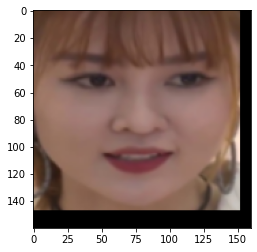

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dataset['4'][0].reshape(INPUT_SIZE,INPUT_SIZE,3))

In [ ]:
res = add_spot_light(dataset['4'][0].reshape(INPUT_SIZE,INPUT_SIZE,3))

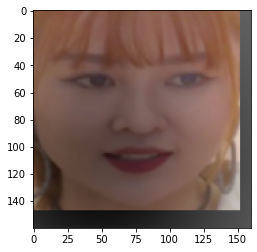

In [ ]:
plt.imshow(res.reshape(INPUT_SIZE,INPUT_SIZE,3))

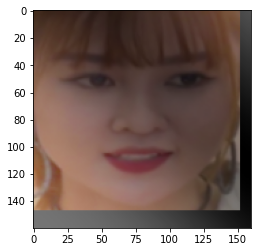

In [ ]:
res = add_parallel_light(dataset['4'][0].reshape(INPUT_SIZE,INPUT_SIZE,3))
plt.imshow(res.reshape(INPUT_SIZE,INPUT_SIZE,3))

In [ ]:
import cv2
import dlib
import numpy as np
import os
from imutils import paths
import pickle
import dlib
aug_data = {}
INPUT_SIZE = 160
for i, label in enumerate(aug_list):
  aug_data[label] = dataset[label]
  values = dataset[label]
  while len(aug_data[label]) < 20:
    face_index = np.random.randint(len(values))
    face = values[face_index].reshape(INPUT_SIZE, INPUT_SIZE, 3)
    aug_type = np.random.randint(4)
    if aug_type == 0:
      flip_image = horizontal_flip(face, True)
      temp = flip_image
      aug_data[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
    if aug_type == 1:
      bright_image = brightness(face, 0.5, 1.5)
      temp = bright_image
      aug_data[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
    if aug_type == 2:
      parallel_light_image = add_parallel_light(face)
      temp = parallel_light_image
      aug_data[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
    if aug_type == 3:
      spot_light_image = add_spot_light(face)
      temp = spot_light_image
      aug_data[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))


  

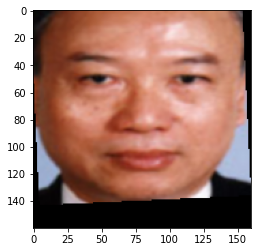

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(aug_data['18'][7].reshape(INPUT_SIZE,INPUT_SIZE,3))

In [ ]:
for key, values in aug_data.items():
  dataset[key] = values

In [ ]:
with open('augment_dataset_27_2.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for key, values in dataset.items():
  dataset[key] = random.sample(values, len(values))

In [ ]:
standardize_data_train = {}
standardize_data_test = {}
for i, (key, values) in enumerate(dataset.items()):
  standardize_data_train[key] = []
  standardize_data_test[key] = []
  for value in values:
    if len(standardize_data_test[key]) == 5:
      break
    face = value.reshape(INPUT_SIZE, INPUT_SIZE, 3)
    temp = standardize(face)
    if len(standardize_data_train[key]) < 15:
      standardize_data_train[key].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
    else:
      standardize_data_test[key].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))

In [ ]:
X_train = None
y_train = None
for i, (key, values) in enumerate(standardize_data_train.items()):
  # print(len(values))
  if X_train is None:
    X_train = np.vstack(values)
    y_train = [i]*X_train.shape[0]
  else:
    # print(X.shape)
    X_ = np.vstack(values)
    y_ = [i]*X_.shape[0]
    X_train = np.vstack((X_train, X_))
    y_train = y_train + y_

In [ ]:
X_test = None
y_test = None
for i, (key, values) in enumerate(standardize_data_test.items()):
  # print(len(values))
  if X_test is None:
    X_test = np.vstack(values)
    y_test = [i]*X_test.shape[0]
  else:
    # print(X.shape)
    X_ = np.vstack(values)
    y_ = [i]*X_.shape[0]
    X_test = np.vstack((X_test, X_))
    y_test = y_test + y_

In [ ]:
nb_classes = len(dataset)
nb_classes

1019

In [ ]:
with open('X_train.pickle', 'wb') as handle:
  pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
  pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_test.pickle', 'wb') as handle:
  pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle', 'wb') as handle:
  pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_train.pickle', 'rb') as handle:
  X_train = pickle.load(handle)
with open('y_train.pickle', 'rb') as handle:
  y_train = pickle.load(handle)
with open('X_test.pickle', 'rb') as handle:
  X_test = pickle.load(handle)
with open('y_test.pickle', 'rb') as handle:
  y_test = pickle.load(handle)

In [ ]:
nb_classes = 1019

In [ ]:
dataset_train = []
dataset_test = []

#Sorting images by classes and normalize values 0=>1
for n in range(nb_classes):
    images_class_n = np.asarray([row for idx,row in enumerate(X_train) if y_train[idx]==n])
    dataset_train.append(images_class_n)
    
    images_class_n = np.asarray([row for idx,row in enumerate(X_test) if y_test[idx]==n])
    dataset_test.append(images_class_n)

In [ ]:
!cp '/content/drive/MyDrive/AsianFace/Dataset/X_test.pickle' './'

# Training

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score

In [ ]:
from pylab import *

In [ ]:
!cp '/content/drive/MyDrive/dbfaces/facenet_keras.h5' 'facenet_keras.h5'

In [ ]:
!cp '/content/drive/MyDrive/dbfaces/facenet_keras_weights.h5' 'facenet_keras_weights.h5'

In [ ]:
base_model = tf.keras.models.load_model('facenet_keras.h5')
base_model.load_weights('facenet_keras_weights.h5')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

In [ ]:
X_train_trm = base_model.predict(X_train[:X_train.shape[0]])
X_test_trm = base_model.predict(X_test[:X_test.shape[0]])

In [ ]:
from sklearn.metrics import accuracy_score

y_preds = []
for vec in X_test_trm:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_trm, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.9479882237487733


In [ ]:
del X_train_trm
del X_test_trm

In [ ]:
img_rows, img_cols = 160, 160

In [ ]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

In [ ]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

In [ ]:
def embedding_model(model_path):
  # Simple convolutional model 
  # used for the embedding model.
  model = tf.keras.models.load_model(model_path)
  return model


class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=1)
        n_dist = K.sum(K.square(anchor-negative), axis=1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train


In [ ]:
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))

    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    #For each pics of our dataset
    print(embeddings[0,:].shape)
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:].reshape(1,-1),embeddings[j,:].reshape(1,-1))
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

In [ ]:
import os
import datetime
LR = 0.00001
network = embedding_model('/content/facenet_keras.h5')
network.load_weights('/content/facenet_keras_weights.h5')
network_train = build_model((160, 160, 3),network)
optimizer = Adam(lr = LR)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Functional (None, 128)          22808144    anchor_input[0][0]               
                                                                 positive_input[0][0]       

Checking batch width, should be 3 :  3
Shapes in the batch A:(2, 160, 160, 3) P:(2, 160, 160, 3) N:(2, 160, 160, 3)
Shapes in the hardbatch A:(2, 160, 160, 3) P:(2, 160, 160, 3) N:(2, 160, 160, 3)


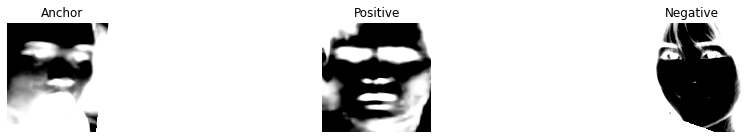

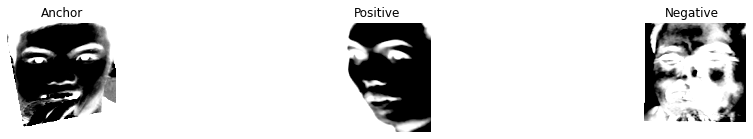

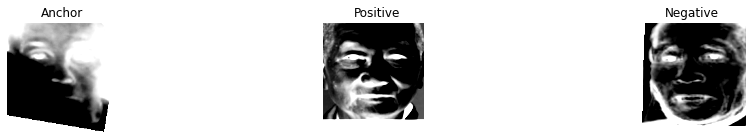

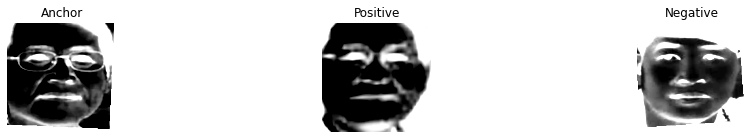

In [ ]:
triplets = get_batch_random(2)
print("Checking batch width, should be 3 : ",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)
hardtriplets = get_batch_hard(50,1,1,network)
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)

(128,)


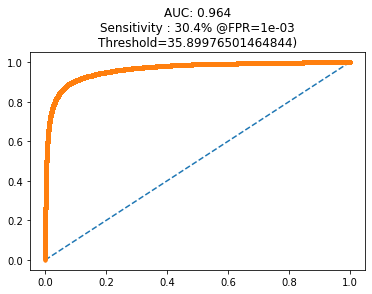

In [ ]:
n_iteration=0
probs,yprob = compute_probs(network, X_test, y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)

In [ ]:
# Hyper parameters
n_iteration = 0
evaluate_every = 10 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 1000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
losses = []
val_losses = []
dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_batch_hard(200,16,16,network)
    loss = network_train.train_on_batch(triplets, None)
    losses.append(loss)
    val_triplets = get_batch_hard(200,16,16,network,s='test')
    val_loss = network_train.test_on_batch(val_triplets, None)
    val_losses.append(val_loss)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        print(val_loss)
        # probs,yprob = compute_probs(network,X_test[:n_val,:,:,:],y_test_origin[:n_val])

    if loss < 1 and val_loss < 1 and abs(loss - val_loss) < 0.1:
      print("\n ------------- \n")
      print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
      print(val_loss)
      break
network.save_weights('weights.h5')

Starting training process!
-------------------------------------

 ------------- 

[10] Time for 10 iterations: 0.7 mins, Train Loss: 217.22244262695312
161.93240356445312

 ------------- 

[20] Time for 20 iterations: 1.0 mins, Train Loss: 88.8819580078125
355.550537109375

 ------------- 

[30] Time for 30 iterations: 1.4 mins, Train Loss: 12.973541259765625
272.7322998046875

 ------------- 

[40] Time for 40 iterations: 1.7 mins, Train Loss: 236.4053192138672
161.13369750976562

 ------------- 

[50] Time for 50 iterations: 2.0 mins, Train Loss: 65.841064453125
322.0948181152344

 ------------- 

[60] Time for 60 iterations: 2.3 mins, Train Loss: 81.95274353027344
40.46270751953125

 ------------- 

[70] Time for 70 iterations: 2.6 mins, Train Loss: 20.23345947265625
3.7079010009765625

 ------------- 

[80] Time for 80 iterations: 2.9 mins, Train Loss: 107.29153442382812
100.96382141113281

 ------------- 

[90] Time for 90 iterations: 3.2 mins, Train Loss: 5.722137451171875
240.0

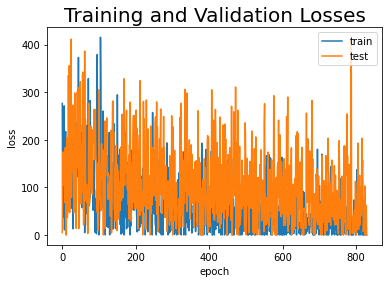

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

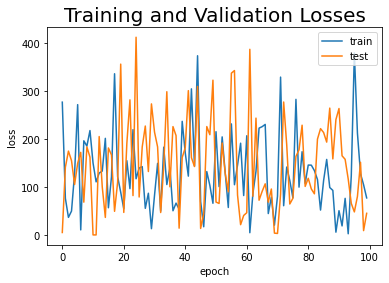

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses[:100])
plt.plot(val_losses[:100])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

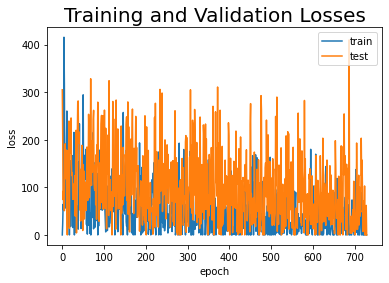

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses[100:])
plt.plot(val_losses[100:])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
base_model = tf.keras.models.load_model('facenet_keras.h5')
base_model.load_weights('weights.h5')

In [ ]:
# from sklearn.manifold import TSNE

X_train_trm = base_model.predict(X_train[:X_train.shape[0]])
X_test_trm = base_model.predict(X_test[:X_test.shape[0]])


# TSNE to use dimensionality reduction to visulaise the resultant embeddings
# tsne = TSNE()
# train_tsne_embeds = tsne.fit_transform(X_train_trm)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

In [ ]:
from sklearn.metrics import accuracy_score

y_preds = []
for vec in X_test_trm:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_trm, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.9521099116781158


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def compute_dist(a,b):
    return np.sum(np.square(a-b))
def compute_probs(X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = X
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                # print(embeddings[i,:].shape)
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:].reshape(1,-1),embeddings[j,:].reshape(1,-1))
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [ ]:
probs, yprobs = compute_probs(X_test_trm, y_test)

In [ ]:
fpr, tpr, thresholds, auc = compute_metrics(probs, yprobs)

In [ ]:
import matplotlib.pyplot as plt
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

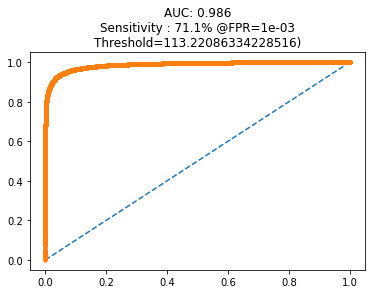

In [ ]:
draw_roc(fpr, tpr, thresholds)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000         5
           2     1.0000    0.6000    0.7500         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    0.8000    0.8889         5
          11     1.0000    0.8000    0.8889         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    1.0000         5
          14     1.0000    1.0000    1.0000         5
          15     1.0000    1.0000    1.0000         5
          16     1.0000    0.8000    0.8889         5
          17     1.0000    